In [54]:
import csv
import pandas as pd
from datetime import datetime
from Levenshtein import distance as levenshtein_distance
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statistics
from fitter import Fitter
import itertools
import multiprocessing
import statsmodels.api as sm

In [55]:
events_final = pd.read_csv('truncated_events_final_twoday.csv') 
print(events_final)

       patientid           events            starttime
0       10002013            CSURG  2160-05-18 01:49:32
1       10002013              ABG  2160-05-18 09:19:00
2       10002013          Calcium  2160-05-18 09:19:00
3       10002013          Glucose  2160-05-18 09:19:00
4       10002013              CBC  2160-05-18 09:19:00
...          ...              ...                  ...
82345   19995790        Bisacodyl  2185-02-03 17:00:00
82346   19995790     Dextrose 50%  2185-02-03 17:00:00
82347   19995790       Ranitidine  2185-02-03 20:00:00
82348   19995790  Docusate Sodium  2185-02-03 20:00:00
82349   19995790       Metoprolol  2185-02-03 20:00:00

[82350 rows x 3 columns]


In [56]:

events_final['starttime'] = pd.to_datetime(events_final['starttime'])

In the next step, we will start to generat the trace

In [57]:

traces = events_final.groupby('patientid')['events'].apply(list).reset_index()
traces['starttimes'] = events_final.groupby('patientid')['starttime'].apply(list).reset_index(drop=True)

In [58]:
print(traces.head())
traces.to_csv('traces.csv', index=False)

   patientid                                             events  \
0   10002013  [CSURG, ABG, Calcium, Glucose, CBC, Electrolyt...   
1   10011398  [CSURG, ABG, Electrolytes, CBC, Glucose, Calci...   
2   10023771  [CSURG, ABG, Calcium, Glucose, CBC, Electrolyt...   
3   10033786  [CSURG, ABG, Calcium, Glucose, CBC, Electrolyt...   
4   10039688  [CSURG, ABG, Calcium, Glucose, CBC, Electrolyt...   

                                          starttimes  
0  [2160-05-18 01:49:32, 2160-05-18 09:19:00, 216...  
1  [2146-12-15 04:53:55, 2146-12-15 07:52:00, 214...  
2  [2113-08-25 03:17:43, 2113-08-25 07:29:00, 211...  
3  [2118-01-16 06:35:16, 2118-01-16 12:00:00, 211...  
4  [2147-05-31 02:31:44, 2147-05-31 07:57:00, 214...  


In [59]:
print(traces['events'].dtype)

object


In [60]:
first_line = traces.iloc[1]['events']
second_line = traces.iloc[2]['events']
print(traces.iloc[1]['events'])
print(traces.iloc[2]['events'])

['CSURG', 'ABG', 'Electrolytes', 'CBC', 'Glucose', 'Calcium', 'Electrolytes', 'ABG', 'CBC', 'Glucose', 'Aspirin', 'ABG', 'Glucose', 'CBC', 'Electrolytes', 'Acetaminophen', 'Nitroglycerin', 'Sterile Water', 'Neostigmine', 'Opioid', 'Influenza Vaccine', 'Potassium Chloride', 'Dextrose 50%', 'Magnesium Sulfate', 'PHENYLEPHrine', 'Milk of Magnesia', 'Sodium Chloride 0.9%  Flush', 'Oxycodone-Acetaminophen', '5% Dextrose', 'Pneumococcal Vaccine', 'Glycopyrrolate', 'Metoclopramide', 'Insulin', 'Propofol', 'Sodium Chloride 0.9%', 'Calcium Gluconate', 'Lactated Ringers', 'ABG', 'Electrolytes', 'CBC', 'Glucose', 'Calcium', 'CBC', 'Sodium Chloride 0.9%', 'CefazoLIN', 'CBC', 'Urea Nitrogen', 'Electrolytes', 'Creatinine', 'Bicarbonate', 'ABG', 'Calcium', 'Glucose', 'Electrolytes', 'ABG', 'Electrolytes', 'Calcium', 'Glucose', 'Ketorolac', 'ABG', 'Glucose', 'Electrolytes', 'Electrolytes', 'CBC', 'Ondansetron', 'Chlorhexidine Gluconate 0.12% Oral Rinse', 'Docusate Sodium', 'Ranitidine', 'Albumin', 'Li

In [61]:
def calculate_hamming_distance(list1, list2, pad_value=None):

    max_len = max(len(list1), len(list2))
    list1_padded = list1 + [pad_value] * (max_len - len(list1))
    list2_padded = list2 + [pad_value] * (max_len - len(list2))
    

    distance = sum(el1 != el2 for el1, el2 in zip(list1_padded, list2_padded))
    return distance

In [62]:

list1 = ['A','B','C','D']
list2 =['A','C','D']


hamming_distance_example = calculate_hamming_distance(list1, list2, pad_value='')
print(f"Hamming distance between list1 and list2: {hamming_distance_example}")

levenshtein_distance_example = levenshtein_distance(list1, list2)
print(f"levenshtein distance between list1 and list2: {levenshtein_distance_example}")

Hamming distance between list1 and list2: 3
levenshtein distance between list1 and list2: 1


In [63]:
first_line = traces.iloc[1]['events']
second_line = traces.iloc[2]['events']
print(traces.iloc[1]['events'])
print(traces.iloc[2]['events'])
print(len(traces.iloc[1]['events']))
print(len(traces.iloc[2]['events']))
hamming_distance_1_2 = calculate_hamming_distance(first_line, second_line)
levenshtein_distance_1_2 = levenshtein_distance(first_line, second_line)
print(f"Hamming distance between the first and second lines: {hamming_distance_1_2}")
print(f"Levenshtein distance between the first and second lines: {levenshtein_distance_1_2}")

['CSURG', 'ABG', 'Electrolytes', 'CBC', 'Glucose', 'Calcium', 'Electrolytes', 'ABG', 'CBC', 'Glucose', 'Aspirin', 'ABG', 'Glucose', 'CBC', 'Electrolytes', 'Acetaminophen', 'Nitroglycerin', 'Sterile Water', 'Neostigmine', 'Opioid', 'Influenza Vaccine', 'Potassium Chloride', 'Dextrose 50%', 'Magnesium Sulfate', 'PHENYLEPHrine', 'Milk of Magnesia', 'Sodium Chloride 0.9%  Flush', 'Oxycodone-Acetaminophen', '5% Dextrose', 'Pneumococcal Vaccine', 'Glycopyrrolate', 'Metoclopramide', 'Insulin', 'Propofol', 'Sodium Chloride 0.9%', 'Calcium Gluconate', 'Lactated Ringers', 'ABG', 'Electrolytes', 'CBC', 'Glucose', 'Calcium', 'CBC', 'Sodium Chloride 0.9%', 'CefazoLIN', 'CBC', 'Urea Nitrogen', 'Electrolytes', 'Creatinine', 'Bicarbonate', 'ABG', 'Calcium', 'Glucose', 'Electrolytes', 'ABG', 'Electrolytes', 'Calcium', 'Glucose', 'Ketorolac', 'ABG', 'Glucose', 'Electrolytes', 'Electrolytes', 'CBC', 'Ondansetron', 'Chlorhexidine Gluconate 0.12% Oral Rinse', 'Docusate Sodium', 'Ranitidine', 'Albumin', 'Li

In [64]:
num_elements = len(traces)
hamming_distance_matrix = pd.DataFrame(index=range(num_elements), columns=range(num_elements))


for i in range(num_elements):
    for j in range(num_elements):
        hamming_distance = calculate_hamming_distance(traces.at[i, "events"], traces.at[j, "events"])
        hamming_distance_matrix.at[i, j] = hamming_distance


print(hamming_distance_matrix)

     0    1    2    3    4    5    6    7    8   9    ... 837  838  839  840  \
0      0  101   96   96  100  101  101  106  105  99  ...  95  101  103  101   
1    101    0   92   91   94   92  100   83   91  91  ...  86   87   94  106   
2     96   92    0   91   90   98  104   96   90  82  ...  94   92   95  102   
3     96   91   91    0   85   98   98   90   79  90  ...  90   88   81  107   
4    100   94   90   85    0   98  100   86   89  89  ...  88   85   89  100   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ..  ...  ..  ...  ...  ...   
842  104   97   98  101   99   95   97   95   93  95  ...  96  100   94  103   
843  104   91   92   95   95   95   98   95   90  91  ...  92   97   97  109   
844  108   95   93   83   88  100   99   93   81  84  ...  91   83   83  104   
845  111  100  101   83   92  104  107   96   89  95  ...  97   93   96  113   
846  105   85   95   88   89   97   99   83   87  84  ...  85   83   89  106   

     841  842  843  844  845  846  
0  

In [65]:

hamming_row_averages = hamming_distance_matrix.mean(axis=1)
print("Hamming row averages:")
print(hamming_row_averages)

Hamming row averages:
0       104.20425
1       96.361275
2        96.61157
3       92.295159
4       93.440378
          ...    
842    101.064935
843     98.641086
844     93.285714
845     96.095632
846     94.139315
Length: 847, dtype: object


In [66]:

hamming_sorted_row_averages = hamming_row_averages.sort_values(ascending=False)


hamming_reordered_matrix = hamming_distance_matrix.loc[hamming_sorted_row_averages.index]

print("Sorted row averages (descending):")
print(hamming_sorted_row_averages)

print("Reordered Hamming distance matrix:")
print(hamming_reordered_matrix)

Sorted row averages (descending):
333    158.456907
416    146.198347
645     145.12987
80     136.680047
728    133.292798
          ...    
372      91.14876
336     91.066116
627     90.994097
430     90.858323
243     90.834711
Length: 847, dtype: object
Reordered Hamming distance matrix:
     0    1    2    3    4    5    6    7    8    9    ...  837  838  839  \
333  152  159  148  156  152  159  158  156  159  160  ...  153  162  159   
416  144  145  142  144  145  148  149  146  145  147  ...  141  141  148   
645  144  142  141  148  143  149  143  144  145  140  ...  141  143  149   
80   134  137  133  136  137  138  139  139  141  137  ...  136  138  141   
728  129  132  130  133  127  139  137  136  137  135  ...  133  135  138   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
372  103   90   89   80   85  106  104   86   82   83  ...   88   86   90   
336  105   90   90   75   90  104  100   89   79   87  ...   94   88   89   
627  102   89

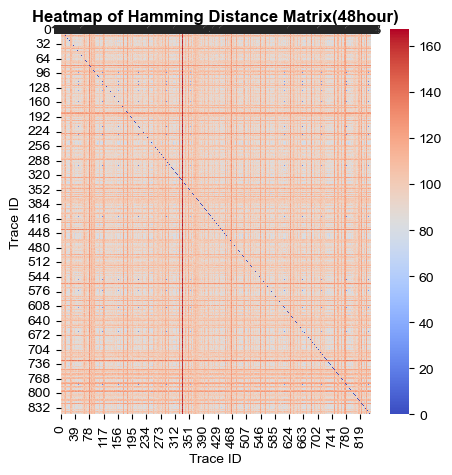

In [67]:
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 10 
})

fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(hamming_distance_matrix.astype(float), annot=True, cmap='coolwarm', fmt='g')

#plt.title('Heatmap of Hamming Distance Matrix(48hour)', fontsize=12, fontweight='bold')
plt.xlabel('Trace ID', fontsize=10)
plt.ylabel('Trace ID', fontsize=10)
plt.savefig('eFigure1_Heatmap of Hamming Distance Matrix(48hour).png', format='png', dpi=300)
plt.show()

In [68]:
levenshtein_distance_matrix = pd.DataFrame(index=range(num_elements), columns=range(num_elements))


for i in range(num_elements):
    for j in range(num_elements):
        dist = levenshtein_distance(traces.at[i, "events"], traces.at[j, "events"])
        levenshtein_distance_matrix.at[i, j] = dist


print(levenshtein_distance_matrix)

    0   1   2   3   4   5   6   7   8   9    ... 837 838 839 840 841 842 843  \
0     0  85  80  71  81  83  85  74  74  75  ...  79  74  76  84  97  85  80   
1    85   0  75  73  74  81  83  73  71  69  ...  76  73  80  83  85  82  82   
2    80  75   0  66  66  75  84  65  65  69  ...  75  76  75  84  85  86  73   
3    71  73  66   0  68  79  75  69  64  72  ...  61  71  70  87  68  76  71   
4    81  74  66  68   0  84  87  68  63  73  ...  72  73  81  77  78  87  86   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ..   
842  85  82  86  76  87  80  82  82  79  84  ...  78  87  77  92  92   0  80   
843  80  82  73  71  86  73  77  77  80  78  ...  75  85  78  95  86  80   0   
844  82  69  76  70  71  86  88  67  61  71  ...  76  67  74  83  78  86  87   
845  94  87  86  68  79  90  90  81  77  81  ...  75  77  82  97  21  89  82   
846  72  72  71  66  74  79  80  65  67  65  ...  73  73  70  83  80  82  82   

    844 845 846  
0    82  94  72  
1  

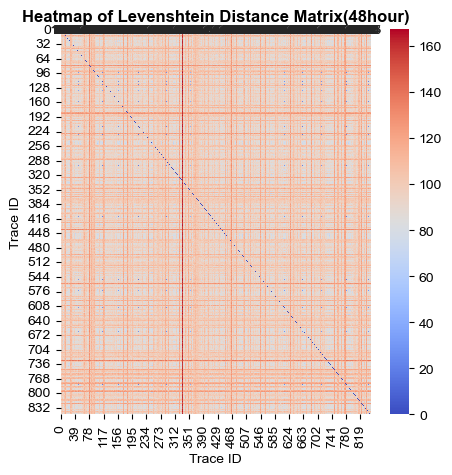

In [69]:
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 10 
})

fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(hamming_distance_matrix.astype(float), annot=True, cmap='coolwarm', fmt='g')

#plt.title('Heatmap of Levenshtein Distance Matrix(48hour)', fontsize=12, fontweight='bold')
plt.xlabel('Trace ID', fontsize=10)
plt.ylabel('Trace ID', fontsize=10)
plt.savefig('eFigure2_Heatmap of Levenshtein Distance Matrix(48hour).png', format='png', dpi=300)
plt.show()

In [70]:

levenshtein_row_averages = levenshtein_distance_matrix.mean(axis=1)


print("Levenshtein row averages:")
print(levenshtein_row_averages)

Levenshtein row averages:
0      83.663518
1      78.990555
2      78.035419
3       73.77686
4      75.733176
         ...    
842    86.847698
843      83.0366
844    75.909091
845    81.774498
846    76.695396
Length: 847, dtype: object


In [71]:
levenshtein_averages = levenshtein_row_averages.tolist()
levenshtein_averages = pd.DataFrame(levenshtein_row_averages, columns=['variation distance'])

print("Levenshtein averages:")
print(levenshtein_averages)

Levenshtein averages:
    variation distance
0            83.663518
1            78.990555
2            78.035419
3             73.77686
4            75.733176
..                 ...
842          86.847698
843            83.0366
844          75.909091
845          81.774498
846          76.695396

[847 rows x 1 columns]


In [72]:

levenshtein_sorted_row_averages = levenshtein_row_averages.sort_values(ascending=False)


levenshtein_reordered_matrix = levenshtein_distance_matrix.loc[levenshtein_sorted_row_averages.index]

print("Sorted row averages (descending):")
print(levenshtein_sorted_row_averages)

print("Reordered Levenshtein distance matrix:")
print(levenshtein_reordered_matrix)

Sorted row averages (descending):
333    125.677686
416    118.951594
645    118.752066
80     108.770956
460     105.35183
          ...    
429      72.22314
372     72.105077
497     71.723731
734     71.619835
627     71.586777
Length: 847, dtype: object
Reordered Levenshtein distance matrix:
     0    1    2    3    4    5    6    7    8    9    ...  837  838  839  \
333  119  129  117  119  121  123  120  125  124  124  ...  116  126  124   
416  114  118  111  121  118  120  114  115  116  118  ...  114  113  119   
645  108  122  109  118  120  118  117  116  112  116  ...  114  115  118   
80   104  110  103  104  106  109  105  111  108  106  ...  103  105  107   
460  101  108   99  100  108   98  101  102  102  101  ...   97  103  100   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
429   82   68   67   60   59   85   86   66   64   66  ...   66   67   76   
372   82   70   72   57   56   88   83   69   62   70  ...   62   68   80   
497   72 

In [73]:
temp_distance = levenshtein_sorted_row_averages.reset_index(drop=True)

top_2_5_percentile = np.percentile(temp_distance, 97.5)
top_5_percentile = np.percentile(temp_distance, 95)
top_10_percentile = np.percentile(temp_distance, 90)
top_20_percentile = np.percentile(temp_distance, 80)
bottom_20_percentile = np.percentile(temp_distance, 20)

print(f"Top 2.5% of the list is above: {top_2_5_percentile}")
print(f"22 th: {levenshtein_sorted_row_averages[21]}")
print(f"Top 5% of the list is above: {top_5_percentile}")
print(f"Top 10% of the list is above: {top_10_percentile}")
print(f"Top 20% of the list is above: {top_20_percentile}")
print(f"Bottom 20% of the list is below: {bottom_20_percentile}")

Top 2.5% of the list is above: 96.97833530106259
22 th: 73.59031877213695
Top 5% of the list is above: 92.82455726092088
Top 10% of the list is above: 88.89964580873672
Top 20% of the list is above: 85.46280991735537
Bottom 20% of the list is below: 76.36953955135773


In [74]:
if not levenshtein_sorted_row_averages.index.equals(hamming_sorted_row_averages.index):
    levenshtein_sorted_row_averages_positions = pd.Series(levenshtein_sorted_row_averages.index, name='levenshtein_sorted_row_averages_index')
    hamming_sorted_row_averages_positions = pd.Series(hamming_sorted_row_averages.index, name='hamming_sorted_row_averages_index')

    comparison_df = pd.DataFrame({'levenshtein_sorted_row_averages_position': levenshtein_sorted_row_averages_positions, 'hamming_sorted_row_averages_position': hamming_sorted_row_averages_positions})
    mismatched_positions = comparison_df[levenshtein_sorted_row_averages_positions != hamming_sorted_row_averages_positions]
    display(comparison_df)  
    print("Mismatched indexes and their positions:")
    display(mismatched_positions)  
else:
    print("Both DataFrames have the same index order.")

,levenshtein_sorted_row_averages_position,hamming_sorted_row_averages_position
0,333,333
1,416,416
2,645,645
3,80,80
4,460,728
...,...,...
842,429,372
843,372,336
844,497,627
845,734,430


Mismatched indexes and their positions:


,levenshtein_sorted_row_averages_position,hamming_sorted_row_averages_position
4,460,728
5,804,460
6,79,804
7,395,440
8,728,263
...,...,...
842,429,372
843,372,336
844,497,627
845,734,430


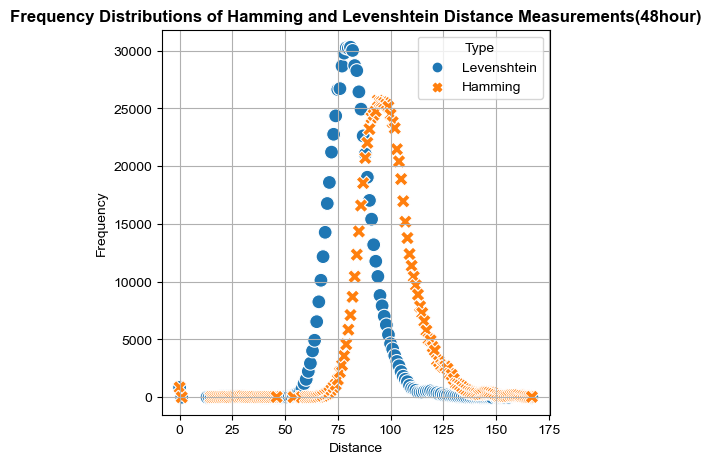

In [75]:
lev_distances = levenshtein_distance_matrix.values.flatten()
ham_distances = hamming_distance_matrix.values.flatten()

lev_unique_distances, lev_counts = np.unique(lev_distances, return_counts=True)
ham_unique_distances, ham_counts = np.unique(ham_distances, return_counts=True)

lev_distance_freq_df = pd.DataFrame({'Distance': lev_unique_distances, 'Frequency': lev_counts, 'Type': 'Levenshtein'})
ham_distance_freq_df = pd.DataFrame({'Distance': ham_unique_distances, 'Frequency': ham_counts, 'Type': 'Hamming'})

distance_freq_df = pd.concat([lev_distance_freq_df, ham_distance_freq_df])


plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 10 
})

fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(data=distance_freq_df, x='Distance', y='Frequency', hue='Type', style='Type', s=100)

#plt.title('Frequency Distributions of Hamming and Levenshtein Distance Measurements(48hour)', fontsize=12, fontweight='bold')
plt.xlabel('Distance', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.savefig('eFigure3_Frequency Distributions of Hamming and Levenshtein Distance Measurements(48hour).png', bbox_inches='tight',format='png', dpi=300)
plt.grid(True)
plt.show()

In [76]:
#Select the top 2.5% and bottom 2.5% lists
top_2_percent_index = int(np.ceil(len(levenshtein_sorted_row_averages) * 0.025))
bottom_2_percent_index = int(np.floor(len(levenshtein_sorted_row_averages) * 0.975))

top_2_percent_lists = levenshtein_reordered_matrix.iloc[:top_2_percent_index]
bottom_2_percent_lists = levenshtein_reordered_matrix.iloc[bottom_2_percent_index:]

In [77]:
# Select the top 5% and bottom 5% lists
top_5_percent_index = int(np.ceil(len(levenshtein_sorted_row_averages) * 0.05))
bottom_5_percent_index = int(np.floor(len(levenshtein_sorted_row_averages) * 0.95))

top_5_percent_lists = levenshtein_reordered_matrix.iloc[:top_5_percent_index]
bottom_5_percent_lists = levenshtein_reordered_matrix.iloc[bottom_5_percent_index:]

In [78]:
# Select the top 10% and bottom 10% lists
top_10_percent_index = int(np.ceil(len(levenshtein_sorted_row_averages) * 0.10))
bottom_10_percent_index = int(np.floor(len(levenshtein_sorted_row_averages) * 0.90))

top_10_percent_lists = levenshtein_reordered_matrix.iloc[:top_10_percent_index]
bottom_10_percent_lists = levenshtein_reordered_matrix.iloc[bottom_10_percent_index:]

In [79]:
# Select the top 20% and bottom 20% lists
top_20_percent_index = int(np.ceil(len(levenshtein_sorted_row_averages) * 0.20))
bottom_20_percent_index = int(np.floor(len(levenshtein_sorted_row_averages) * 0.80))

top_20_percent_lists = levenshtein_reordered_matrix.iloc[:top_20_percent_index]
bottom_20_percent_lists = levenshtein_reordered_matrix.iloc[bottom_20_percent_index:]

In [80]:
print("Top 2.5% lists:")
print(top_2_percent_lists)
print("Bottom 2.5% lists:")
print(bottom_2_percent_lists)

top_2_percent_index = top_2_percent_lists.index.tolist()
print("PatientID of Top 2.5% traces:")
print(top_2_percent_lists.index.tolist())
bottom_2_percent_index = bottom_2_percent_lists.index.tolist()
print("PatientID of Bottom 2.5% traces:")
print(bottom_2_percent_lists.index.tolist())

Top 2.5% lists:
     0    1    2    3    4    5    6    7    8    9    ...  837  838  839  \
333  119  129  117  119  121  123  120  125  124  124  ...  116  126  124   
416  114  118  111  121  118  120  114  115  116  118  ...  114  113  119   
645  108  122  109  118  120  118  117  116  112  116  ...  114  115  118   
80   104  110  103  104  106  109  105  111  108  106  ...  103  105  107   
460  101  108   99  100  108   98  101  102  102  101  ...   97  103  100   
804   93   97   99  101  100  104  103   97   97  100  ...   97   99   98   
79   100  102  100  103  106   97  104  100   97  100  ...  103  104   97   
395  102  108   99   99  101  102   97  104  106  105  ...   98  101  105   
728  100  105   96   99   97  107  104  108  101  101  ...  100  100  108   
214   98   98   91  102   93  107  103   99   94   96  ...   99  103  100   
184  105  101   99  103  102  102  105   99  101  101  ...  100   99  104   
263   96  102   96   98  100   97   98   96   99   93  ...  

In [81]:
complete_patients_clinical = pd.read_csv('completepatients.csv')
complete_patients = pd.concat([complete_patients_clinical,levenshtein_averages], axis=1)
print(complete_patients.head())

   subject_id   hadm_id  age gender insurance language                race  \
0    10002013  23581541   57      F  Medicare  ENGLISH               OTHER   
1    10011398  27505812   67      M     Other  ENGLISH  HISPANIC OR LATINO   
2    10023771  20044587   70      M  Medicare  ENGLISH               WHITE   
3    10033786  27383470   50      M     Other  ENGLISH               WHITE   
4    10039688  26345871   63      F  Medicare  ENGLISH               WHITE   

  marital_status  myocardial_infarct  congestive_heart_failure  ...  \
0         SINGLE                   1                         1  ...   
1        MARRIED                   0                         0  ...   
2        MARRIED                   0                         0  ...   
3        MARRIED                   0                         0  ...   
4        MARRIED                   1                         0  ...   

   renal_disease  malignant_cancer  severe_liver_disease  \
0              0                 0          

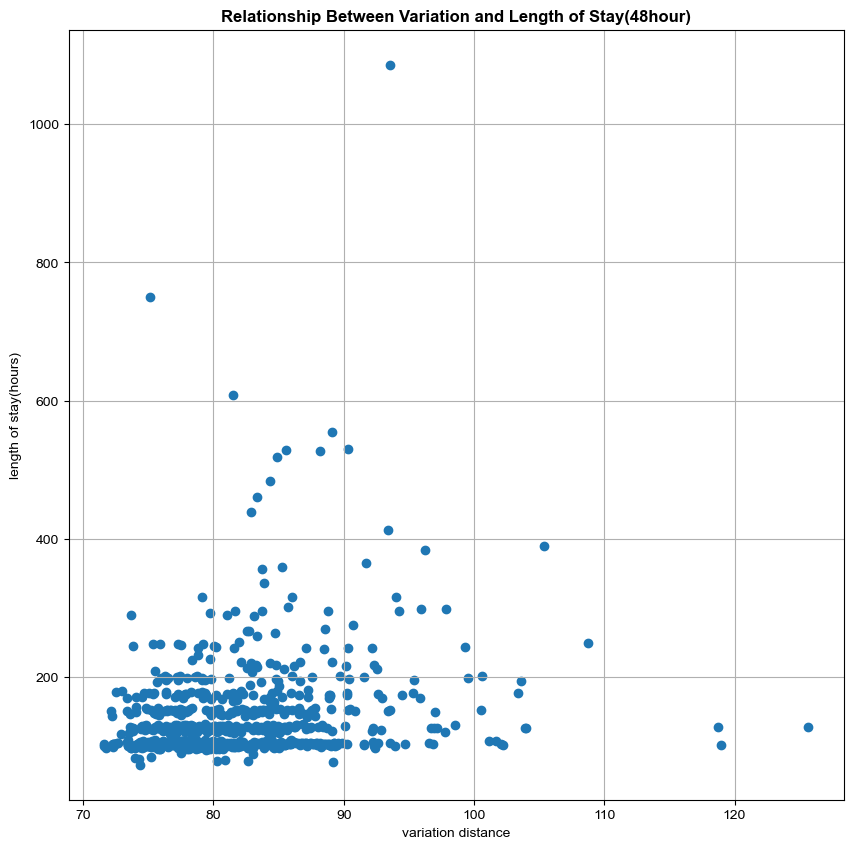

In [82]:

plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 10 
})

fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(complete_patients['variation distance'],complete_patients['length_of_stay'])

#plt.title('Relationship Between Variation and Length of Stay(48hour)', fontsize=12, fontweight='bold')
plt.xlabel('variation distance', fontsize=10)
plt.ylabel('length of stay(hours)', fontsize=10)
plt.savefig('Figure_Relationship Between Variation and Length of Stay(48hour).png', bbox_inches='tight',format='png', dpi=800)
plt.grid(True)
plt.show()

In [83]:
#print(complete_patients.dtypes)
complete_patients['distance'] = pd.to_numeric(complete_patients['variation distance'], errors='coerce')

In [84]:
complete_patients['age_group'] = pd.cut(complete_patients['age'], bins=[20, 30, 40, 50, 60, 70, 80, 90, 100],
                         labels=['20-30', '31-40', '41-50', '51-60', '61-70','71-80','81-90','91-100'])

In [85]:
def categorize_cci(cci):
    if 10 <= cci <= 12:
        return '10-12'
    elif 8 <= cci < 10:
        return '8-10'
    elif 6 <= cci < 8:
        return '6-8'
    elif 4 <= cci < 6:  
        return '4-6'
    elif 2 <= cci < 4:  
        return '2-4'
    elif 0 <= cci < 2:
        return '0-2'
complete_patients['cci_group'] = complete_patients['cci'].apply(categorize_cci)

In [86]:
'''
def categorize_distance(distance):
    if distance >= 96:
        return 'top2.5%'
    elif distance >= 92:
        return 'top5%'
    elif distance >= 88:
        return 'top10%'
    elif distance >= 85:  
        return 'top20%'
    elif 76 < distance < 85:  
        return 'middle value'
    elif distance <= 76:  
        return 'bottom20%'
'''
def categorize_distance(distance):
    if distance >= 85:  
        return 'top20%'
    else:
        return 'Other'
complete_patients['distance_group'] = complete_patients['distance'].apply(categorize_distance)

In [87]:
print(complete_patients.head())
#complete_patients.to_csv('test.csv',index = False)
value_counts = complete_patients['distance_group'].value_counts()
print(value_counts)

   subject_id   hadm_id  age gender insurance language                race  \
0    10002013  23581541   57      F  Medicare  ENGLISH               OTHER   
1    10011398  27505812   67      M     Other  ENGLISH  HISPANIC OR LATINO   
2    10023771  20044587   70      M  Medicare  ENGLISH               WHITE   
3    10033786  27383470   50      M     Other  ENGLISH               WHITE   
4    10039688  26345871   63      F  Medicare  ENGLISH               WHITE   

  marital_status  myocardial_infarct  congestive_heart_failure  ...  aids  \
0         SINGLE                   1                         1  ...     0   
1        MARRIED                   0                         0  ...     0   
2        MARRIED                   0                         0  ...     0   
3        MARRIED                   0                         0  ...     0   
4        MARRIED                   1                         0  ...     0   

   cci  in_hospital_mortality  died_within_30_days  length_of_stay  

In [88]:
complete_patients['race'] = complete_patients['race'].str.split(' ').str[0]
complete_patients['race']= complete_patients['race'].replace(['BLACK/AFRICAN', 'BLACK/CARIBBEAN','BLACK/CAPE','HISPANIC/LATINO','HISPANIC','PATIENT', 'UNABLE','SOUTH','PORTUGUESE','MULTIPLE','OTHER','ASIAN','UNKNOWN'], 'OTHER')
value_counts_race = complete_patients['race'].value_counts()
print(value_counts_race)

race
WHITE    667
OTHER    180
Name: count, dtype: int64


In [89]:
value_counts_gender = complete_patients['gender'].value_counts()
print(value_counts_gender)
value_counts_insurance = complete_patients['insurance'].value_counts()
print(value_counts_insurance)

gender
M    701
F    146
Name: count, dtype: int64
insurance
Other       506
Medicare    313
Medicaid     28
Name: count, dtype: int64


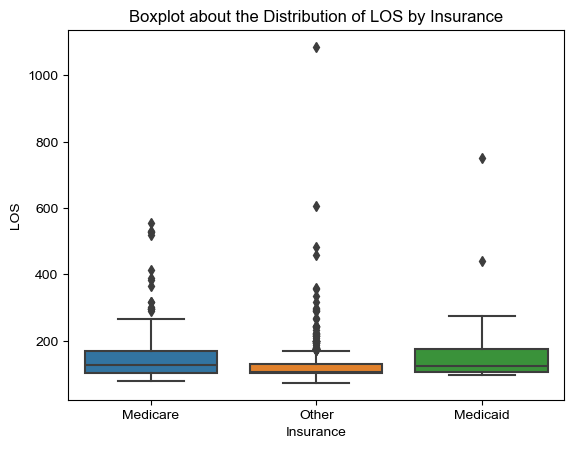

In [90]:
sns.boxplot(x='insurance', y='length_of_stay', data=complete_patients[['insurance','length_of_stay']])
plt.title('Boxplot about the Distribution of LOS by Insurance')
plt.xlabel('Insurance')
plt.ylabel('LOS')
plt.show()

In [91]:
import statsmodels.formula.api as smf

y = complete_patients['length_of_stay']
model = smf.ols('y ~ distance_group + age + cci + C(gender) + C(insurance) + C(race)', data=complete_patients).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     16.31
Date:                Thu, 06 Feb 2025   Prob (F-statistic):           3.21e-20
Time:                        16:40:13   Log-Likelihood:                -4780.6
No. Observations:                 847   AIC:                             9577.
Df Residuals:                     839   BIC:                             9615.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [92]:
print(complete_patients.columns)

Index(['subject_id', 'hadm_id', 'age', 'gender', 'insurance', 'language',
       'race', 'marital_status', 'myocardial_infarct',
       'congestive_heart_failure', 'peripheral_vascular_disease',
       'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease',
       'rheumatic_disease', 'peptic_ulcer_disease', 'mild_liver_disease',
       'diabetes_without_cc', 'diabetes_with_cc', 'paraplegia',
       'renal_disease', 'malignant_cancer', 'severe_liver_disease',
       'metastatic_solid_tumor', 'aids', 'cci', 'in_hospital_mortality',
       'died_within_30_days', 'length_of_stay', 'variation distance',
       'distance', 'age_group', 'cci_group', 'distance_group'],
      dtype='object')


In [93]:
top_2_percent = complete_patients.loc[top_2_percent_index]
print(top_2_percent)
output_path = 'top_2_percent.csv'
top_2_percent.to_csv(output_path, index=False)
top_2_percent_los = top_2_percent['length_of_stay'].mean()
print(f"The average of LOS is: {top_2_percent_los}")
top_2_percent_in_hospital_mortality = top_2_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {top_2_percent_in_hospital_mortality}")
top_2_percent_30_day_mortality = top_2_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {top_2_percent_30_day_mortality}")
top_2_percent_cci =top_2_percent['cci'].mean()
print(f"The average of CCI is: {top_2_percent_cci}")
top_2_percent_top3cci_averages = top_2_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
top_2_percent_top3cci = top_2_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(top_2_percent_top3cci)

     subject_id   hadm_id  age gender insurance language   race  \
333    14195255  27013153   74      M  Medicare  ENGLISH  WHITE   
416    15156174  27191368   51      M     Other  ENGLISH  WHITE   
645    17641873  21705480   81      M     Other  ENGLISH  WHITE   
80     11076206  20326682   63      F  Medicare  ENGLISH  WHITE   
460    15610823  26657269   69      F  Medicare  ENGLISH  WHITE   
804    19559236  28407617   65      M     Other  ENGLISH  OTHER   
79     11047016  22671173   75      M  Medicare  ENGLISH  WHITE   
395    14908025  23478116   60      M     Other  ENGLISH  OTHER   
728    18669132  21506797   40      M     Other  ENGLISH  OTHER   
214    12782295  28711743   62      M     Other  ENGLISH  WHITE   
184    12445879  20738275   71      M  Medicare  ENGLISH  WHITE   
263    13424432  25591079   55      M     Other  ENGLISH  WHITE   
467    15708357  20482084   52      M  Medicare  ENGLISH  WHITE   
440    15417736  23735688   62      F  Medicare  ENGLISH  OTHE

In [94]:
# Display the top 5% lists
print("Top 5% lists:")
print(top_5_percent_lists)

# Display the bottom 5% lists
print("Bottom 5% lists:")
print(bottom_5_percent_lists)

top_5_percent_index = top_5_percent_lists.index.tolist()
print("PatientID of Top 5% traces:")
print(top_5_percent_lists.index.tolist())
bottom_5_percent_index = bottom_5_percent_lists.index.tolist()
print("PatientID of Bottom 5% traces:")
print(bottom_5_percent_lists.index.tolist())

Top 5% lists:
     0    1    2    3    4    5    6    7    8    9    ...  837  838  839  \
333  119  129  117  119  121  123  120  125  124  124  ...  116  126  124   
416  114  118  111  121  118  120  114  115  116  118  ...  114  113  119   
645  108  122  109  118  120  118  117  116  112  116  ...  114  115  118   
80   104  110  103  104  106  109  105  111  108  106  ...  103  105  107   
460  101  108   99  100  108   98  101  102  102  101  ...   97  103  100   
804   93   97   99  101  100  104  103   97   97  100  ...   97   99   98   
79   100  102  100  103  106   97  104  100   97  100  ...  103  104   97   
395  102  108   99   99  101  102   97  104  106  105  ...   98  101  105   
728  100  105   96   99   97  107  104  108  101  101  ...  100  100  108   
214   98   98   91  102   93  107  103   99   94   96  ...   99  103  100   
184  105  101   99  103  102  102  105   99  101  101  ...  100   99  104   
263   96  102   96   98  100   97   98   96   99   93  ...   9

In [95]:
# Display the top 10% lists
print("Top 10% lists:")
print(top_10_percent_lists)

# Display the bottom 10% lists
print("Bottom 10% lists:")
print(bottom_10_percent_lists)

top_10_percent_index = top_10_percent_lists.index.tolist()
print("PatientID of Top 10% traces:")
print(top_10_percent_lists.index.tolist())
bottom_10_percent_index = bottom_10_percent_lists.index.tolist()
print("PatientID of Bottom 10% traces:")
print(bottom_10_percent_lists.index.tolist())

Top 10% lists:
     0    1    2    3    4    5    6    7    8    9    ...  837  838  839  \
333  119  129  117  119  121  123  120  125  124  124  ...  116  126  124   
416  114  118  111  121  118  120  114  115  116  118  ...  114  113  119   
645  108  122  109  118  120  118  117  116  112  116  ...  114  115  118   
80   104  110  103  104  106  109  105  111  108  106  ...  103  105  107   
460  101  108   99  100  108   98  101  102  102  101  ...   97  103  100   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
756   84   89   83   82   82   92   95   91   79   83  ...   81   78   90   
805   97   92   91   87   83   93   93   88   90   90  ...   88   85   89   
793   87   87   83   88   74   94   92   85   83   87  ...   87   83   89   
794   90   92   81   89   83   96   96   82   86   85  ...   80   78   94   
499   85   84   87   86   88   84   87   83   82   81  ...   87   85   83   

     840  841  842  843  844  845  846  
333  127  150  126 

In [96]:
# Display the top 20% lists
print("Top 20% lists:")
print(top_20_percent_lists)

# Display the bottom 20% lists
print("Bottom 20% lists:")
print(bottom_20_percent_lists)

top_20_percent_index = top_20_percent_lists.index.tolist()
print("PatientID of Top 20% traces:")
print(top_20_percent_lists.index.tolist())
bottom_20_percent_index = bottom_20_percent_lists.index.tolist()
print("PatientID of Bottom 20% traces:")
print(bottom_20_percent_lists.index.tolist())

Top 20% lists:
     0    1    2    3    4    5    6    7    8    9    ...  837  838  839  \
333  119  129  117  119  121  123  120  125  124  124  ...  116  126  124   
416  114  118  111  121  118  120  114  115  116  118  ...  114  113  119   
645  108  122  109  118  120  118  117  116  112  116  ...  114  115  118   
80   104  110  103  104  106  109  105  111  108  106  ...  103  105  107   
460  101  108   99  100  108   98  101  102  102  101  ...   97  103  100   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
638   85   87   83   80   86   89   89   79   83   83  ...   76   82   88   
812   86   81   85   78   85   80   83   82   75   84  ...   85   86   77   
140   89   80   87   85   80   91   93   83   82   84  ...   86   79   86   
90    82   76   74   77   77   85   88   79   74   84  ...   78   79   84   
283   91   80   77   83   75   94   95   80   77   86  ...   83   78   86   

     840  841  842  843  844  845  846  
333  127  150  126 

In [97]:
top_5_percent = complete_patients.loc[top_5_percent_index]
output_path = 'top_5_percent.csv'
top_5_percent.to_csv(output_path, index=False)
top_5_percent_los = top_5_percent['length_of_stay'].mean()
print(f"The average of LOS is: {top_5_percent_los}")
top_5_percent_in_hospital_mortality = top_5_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {top_5_percent_in_hospital_mortality}")
top_5_percent_30_day_mortality = top_5_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {top_5_percent_30_day_mortality}")
top_5_percent_cci =top_5_percent['cci'].mean()
print(f"The average of CCI is: {top_5_percent_cci}")
top_5_percent_top3cci_averages = top_5_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
top_5_percent_top3cci = top_5_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(top_5_percent_top3cci)

The average of LOS is: 198.3627906976744
The average of in_hospital_mortality is: 0.023255813953488372
The average of 30_day_mortality is: 0.023255813953488372
The average of CCI is: 4.441860465116279
Top3 CCI:
diabetes_without_cc         0.418605
renal_disease               0.348837
congestive_heart_failure    0.255814
dtype: float64


In [98]:
top_10_percent = complete_patients.loc[top_10_percent_index]
output_path = 'top_10_percent.csv'
top_10_percent.to_csv(output_path, index=False)
top_10_percent_los = top_10_percent['length_of_stay'].mean()
print(f"The average of LOS is: {top_10_percent_los}")
top_10_percent_in_hospital_mortality = top_10_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {top_10_percent_in_hospital_mortality}")
top_10_percent_30_day_mortality = top_10_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {top_10_percent_30_day_mortality}")
top_10_percent_cci =top_10_percent['cci'].mean()
print(f"The average of CCI is: {top_10_percent_cci}")
top_10_percent_top3cci_averages = top_10_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
top_10_percent_top3cci = top_10_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(top_10_percent_top3cci)

The average of LOS is: 185.90745098039218
The average of in_hospital_mortality is: 0.03529411764705882
The average of 30_day_mortality is: 0.03529411764705882
The average of CCI is: 4.447058823529412
Top3 CCI:
diabetes_without_cc          0.364706
renal_disease                0.294118
chronic_pulmonary_disease    0.258824
dtype: float64


In [99]:
top_20_percent = complete_patients.loc[top_20_percent_index]
output_path = 'top_20_percent.csv'
top_20_percent.to_csv(output_path, index=False)
top_20_percent_los = top_20_percent['length_of_stay'].mean()
print(f"The average of LOS is: {top_20_percent_los}")
top_20_percent_in_hospital_mortality = top_20_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {top_20_percent_in_hospital_mortality}")
top_20_percent_30_day_mortality = top_20_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {top_20_percent_30_day_mortality}")
top_20_percent_cci =top_20_percent['cci'].mean()
print(f"The average of CCI is: {top_20_percent_cci}")
top_20_percent_top3cci_averages = top_20_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
top_20_percent_top3cci = top_20_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(top_20_percent_top3cci)

The average of LOS is: 167.39333333333332
The average of in_hospital_mortality is: 0.029411764705882353
The average of 30_day_mortality is: 0.029411764705882353
The average of CCI is: 4.41764705882353
Top3 CCI:
diabetes_without_cc    0.417647
renal_disease          0.247059
myocardial_infarct     0.235294
dtype: float64


In [100]:
bottom_5_percent = complete_patients.loc[bottom_5_percent_index]
output_path = 'bottom_5_percent.csv'
bottom_5_percent.to_csv(output_path, index=False)
bottom_5_percent_los = bottom_5_percent['length_of_stay'].mean()
print(f"The average of LOS is: {bottom_5_percent_los}")
bottom_5_percent_in_hospital_mortality = bottom_5_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {bottom_5_percent_in_hospital_mortality}")
bottom_5_percent_30_day_mortality = bottom_5_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {bottom_5_percent_30_day_mortality}")
bottom_5_percent_cci =bottom_5_percent['cci'].mean()
print(f"The average of CCI is: {bottom_5_percent_cci}")

bottom_5_percent_top3cci_averages = bottom_5_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
bottom_5_percent_top3cci = bottom_5_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(bottom_5_percent_top3cci)

The average of LOS is: 125.10852713178298
The average of in_hospital_mortality is: 0.023255813953488372
The average of 30_day_mortality is: 0.023255813953488372
The average of CCI is: 2.9767441860465116
Top3 CCI:
diabetes_without_cc          0.255814
myocardial_infarct           0.139535
chronic_pulmonary_disease    0.116279
dtype: float64


In [101]:
bottom_10_percent = complete_patients.loc[bottom_10_percent_index]
output_path = 'bottom_10_percent.csv'
bottom_10_percent.to_csv(output_path, index=False)
bottom_10_percent_los = bottom_10_percent['length_of_stay'].mean()
print(f"The average of LOS is: {bottom_10_percent_los}")
bottom_10_percent_in_hospital_mortality = bottom_10_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {bottom_10_percent_in_hospital_mortality}")
bottom_10_percent_30_day_mortality = bottom_10_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {bottom_10_percent_30_day_mortality}")
bottom_10_percent_cci =bottom_10_percent['cci'].mean()
print(f"The average of CCI is: {bottom_10_percent_cci}")

bottom_10_percent_top3cci_averages = bottom_10_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
bottom_10_percent_top3cci = bottom_10_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(bottom_10_percent_top3cci)

The average of LOS is: 127.8021568627451
The average of in_hospital_mortality is: 0.011764705882352941
The average of 30_day_mortality is: 0.011764705882352941
The average of CCI is: 3.152941176470588
Top3 CCI:
diabetes_without_cc            0.270588
myocardial_infarct             0.164706
peripheral_vascular_disease    0.141176
dtype: float64


In [102]:
bottom_20_percent = complete_patients.loc[bottom_20_percent_index]
output_path = 'bottom_20_percent.csv'
bottom_20_percent.to_csv(output_path, index=False)
bottom_20_percent_los = bottom_20_percent['length_of_stay'].mean()
print(f"The average of LOS is: {bottom_20_percent_los}")
bottom_20_percent_in_hospital_mortality = bottom_20_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {bottom_20_percent_in_hospital_mortality}")
bottom_20_percent_30_day_mortality = bottom_20_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {bottom_20_percent_30_day_mortality}")
bottom_20_percent_cci =bottom_20_percent['cci'].mean()
print(f"The average of CCI is: {bottom_20_percent_cci}")

bottom_20_percent_top3cci_averages = bottom_20_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
bottom_20_percent_top3cci = bottom_20_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(bottom_20_percent_top3cci)

The average of LOS is: 126.5764705882353
The average of in_hospital_mortality is: 0.0058823529411764705
The average of 30_day_mortality is: 0.011764705882352941
The average of CCI is: 3.4352941176470586
Top3 CCI:
diabetes_without_cc          0.323529
myocardial_infarct           0.247059
chronic_pulmonary_disease    0.111765
dtype: float64


In [103]:
#X = complete_patients[['age','cci','myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']]

In [104]:
traces_top_2_percent = traces.iloc[top_2_percent_index]
top_2_percent_patient = traces_top_2_percent['patientid']
print(top_2_percent_patient)
events_final_top_2_percent = events_final[events_final['patientid'].isin(top_2_percent_patient)]
print(events_final_top_2_percent)
events_final_top_2_percent.to_csv('events_final_top_2_percent.csv', index=False)

333    14195255
416    15156174
645    17641873
80     11076206
460    15610823
804    19559236
79     11047016
395    14908025
728    18669132
214    12782295
184    12445879
263    13424432
467    15708357
440    15417736
558    16688809
170    12253915
748    18942549
796    19514121
685    18083865
100    11318805
94     11162509
276    13651772
Name: patientid, dtype: int64
       patientid            events           starttime
7742    11047016             CSURG 2179-10-25 05:24:30
7743    11047016  Milk of Magnesia 2179-10-25 10:00:00
7744    11047016           Aspirin 2179-10-25 10:00:00
7745    11047016               CBC 2179-10-25 10:22:00
7746    11047016               ABG 2179-10-25 10:22:00
...          ...               ...                 ...
78352   19559236   Docusate Sodium 2115-06-28 20:00:00
78353   19559236        Ranitidine 2115-06-28 20:00:00
78354   19559236          Diuretic 2115-06-28 20:00:00
78355   19559236        Amiodarone 2115-06-28 20:00:00
78356   19559

In [105]:
traces_top_5_percent = traces.iloc[top_5_percent_index]
top_5_percent_patient = traces_top_5_percent['patientid']
print(top_5_percent_patient)
events_final_top_5_percent = events_final[events_final['patientid'].isin(top_5_percent_patient)]
print(events_final_top_5_percent)
events_final_top_5_percent.to_csv('events_final_top_5_percent.csv', index=False)

333    14195255
416    15156174
645    17641873
80     11076206
460    15610823
804    19559236
79     11047016
395    14908025
728    18669132
214    12782295
184    12445879
263    13424432
467    15708357
440    15417736
558    16688809
170    12253915
748    18942549
796    19514121
685    18083865
100    11318805
94     11162509
276    13651772
91     11125397
325    14126955
299    13963514
228    12949905
778    19359798
498    16035306
286    13751917
367    14623728
628    17466817
673    17904699
182    12433486
240    13139482
172    12288757
640    17606143
822    19723798
629    17475392
361    14560728
349    14369707
607    17244760
358    14546527
560    16695100
Name: patientid, dtype: int64
       patientid            events           starttime
7742    11047016             CSURG 2179-10-25 05:24:30
7743    11047016  Milk of Magnesia 2179-10-25 10:00:00
7744    11047016           Aspirin 2179-10-25 10:00:00
7745    11047016               CBC 2179-10-25 10:22:00
7746   

In [106]:
traces_bottom_20_percent = traces.iloc[bottom_20_percent_index]
bottom_20_percent_patient = traces_bottom_20_percent['patientid']
print(bottom_20_percent_patient)
events_final_bottom_20_percent = events_final[events_final['patientid'].isin(bottom_20_percent_patient)]
print(events_final_bottom_20_percent)
events_final_bottom_20_percent.to_csv('events_final_bottom_20_percent.csv', index=False)

138    11875538
46     10666266
356    14487213
581    16934858
683    18043576
         ...   
429    15239801
372    14724431
497    16019747
734    18716421
627    17458909
Name: patientid, Length: 170, dtype: int64
       patientid                       events           starttime
313     10033786                        CSURG 2118-01-16 06:35:16
314     10033786                          ABG 2118-01-16 12:00:00
315     10033786                      Calcium 2118-01-16 12:00:00
316     10033786                      Glucose 2118-01-16 12:00:00
317     10033786                          CBC 2118-01-16 12:00:00
...          ...                          ...                 ...
82215   19975223  Sodium Chloride 0.9%  Flush 2172-07-25 15:00:00
82216   19975223  Heparin Flush (10 units/ml) 2172-07-25 17:00:00
82217   19975223                   Metoprolol 2172-07-25 20:00:00
82218   19975223              Docusate Sodium 2172-07-25 20:00:00
82219   19975223                   Ranitidine 2172-07-2